In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import os
import time
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [3]:
# Dataset loading
file_path = '/content/final_dataset_encoded.csv'
df = pd.read_csv(file_path)

print("Dataset's first rows:")
print(df.head())

Dataset's first rows:
   FL_DATE  AIRLINE  AIRLINE_DOT  AIRLINE_CODE  DOT_CODE  FL_NUMBER  ORIGIN  \
0        8       17           17            14     19977       1562     131   
1     1418        3            3             4     19790       1149     247   
2     1298       17           17            14     19977        459      99   
3     1525        3            3             4     19790       2295     247   
4      418       16           16            10     20416        407     223   

   ORIGIN_CITY  DEST  DEST_CITY  CRS_DEP_TIME  DEP_DELAY  WHEELS_OFF  \
0          118   123        240          1155       -4.0      1210.0   
1          220   323        318          2120       -6.0      2123.0   
2           89   247        220           954        6.0      1020.0   
3          220   325        303          1609       -1.0      1635.0   
4          254   100         83          1840       -2.0      1853.0   

   WHEELS_ON  CRS_ARR_TIME  ARR_TIME  CRS_ELAPSED_TIME  DISTANCE  
0  

# MODEL BUILD
**Ada Boost Regressor** (Adaptive Boosting Regressor) is an iterative boosting alghoritm that obtains different models by reweighting the training data at every iteration. Indeed, for each iteration it saves and updates the weight of instances and weight of models. It increases the weight of incorrectly predicted samples, while decreases the weight of correctly predicted ones, depending on the accuracy of each model at each iteration. Better models are considered as more reliable and therefore instances’ weight is greater increased or decreased, and viceversa. Then, at greater values of iteration the error (squared loss) of each model decreases. Finally, it uses as default a shinkage value equal to 1, leading to faster but less precise training, but this lack of precision is mitigated with a larger number of trees (400).

**Gradient Boosting Regressor** is a variant of the previous one and it is based on the same rationale. Nevertheless, instead of assigning greater weights to misclassified instances, it predicts the residual error of the previous iterates, and tries to minimize it according to a loss function (squared loss). Finally, it uses as default a shinkage value equal to 0.1, leading to slower but more precise training, but this slowness is mitigated with a lower number of trees (250).

**XGBoost** (Extreme Gradient Boosting) is another iterative boosting algorithm that builds decision trees sequentially, where each tree corrects the errors of the previous ones. It optimizes an objective function that includes both a loss function (mean squared error) and a regularization term (L1 and L2) to prevent overfitting. It tries to predict residuals as the previous one, but differently from it, it applies a sort of residual discretization, using approximated quantiles, leading to faster but less precise training. Therefore, in order to mitigate this lack of precision the number of trees is increased (300), but keeping it lower than the one used for AdaBoost since it uses a greater default a shinkage value equal to 0.3.

**Random Forest Regressor** selects a random subset of the training data using bootstrap sampling (with replacement); each decision tree is trained on a different boostrap sample; at each split in a tree, a random subset of features is selected (equivalent to the sqrt of features), and the best feature is chosen based on a splitting criterion (squared error) and finally, predictions from all trees are averaged in regression tasks to obtain the final output.

**Extra Trees Regressor** (Extremely Randomized Trees) unlike Random Forest, no bootstrapping is performed; instead, the entire dataset is used for training each tree; at each node, a random subset of features is selected (also here equivalent to the sqrt of features), but instead of choosing the best split based on a threshold applied on the chosen criterion (also here squared error), the threshold is chosen randomly; and finally, the final prediction is obtained by averaging the outputs of all trees.


In [4]:
# Feature target separation
X = df.drop(columns=["DEP_DELAY"])
y = df["DEP_DELAY"]

In [5]:
# Train-test split (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Models' saving
save_path = "/content/saved_models"
os.makedirs(save_path, exist_ok=True)

In [10]:
# Boosting Models' definition
boostingModels = {
    "AdaBoost": AdaBoostRegressor(n_estimators=400, loss='square', random_state=42),  # learning_rate [default=1.0]; max_depth [default=3]
    "GradientBoosting": GradientBoostingRegressor(n_estimators=250, max_depth=15, random_state=42),  # learning_rate [default=0.1]; loss [default='squared_error']
    "XGBoost": XGBRegressor(n_estimators=300, max_depth=15, n_jobs=-1, random_state=42), # learning_rate [default=0.3]; objective [default=squarederror]; reg_lambda(L2) [default=1]; reg_alpha(L1) [default=0]
}

In [11]:
trained_boosting_models = {}

# Training Boosting models
for name, model in boostingModels.items():
    print(f"\nTraining model: {name}")

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    trained_boosting_models[name] = (model, train_time)

    filename = f"{save_path}/{name}.pkl"
    joblib.dump(model, filename)
    print(f"Model {name} saved in {filename}")


Training model: AdaBoost
Model AdaBoost saved in /content/saved_models/AdaBoost.pkl

Training model: GradientBoosting
Model GradientBoosting saved in /content/saved_models/GradientBoosting.pkl

Training model: XGBoost
Model XGBoost saved in /content/saved_models/XGBoost.pkl


In [7]:
# Bagging Models' definition
baggingModels = {
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=20, max_features="log2", n_jobs=-1, random_state=42), # criterion [default='squared_error']; bootstrap [default=True];
    "ExtraTrees": ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features="log2", n_jobs=-1, random_state=42) # criterion [default='squared_error']; bootstrap [default=False];
}

In [8]:
trained_bagging_models = {}

# Training Bagging models
for name, model in baggingModels.items():
    print(f"\nTraining model: {name}")

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    trained_bagging_models[name] = (model, train_time)

    filename = f"{save_path}/{name}.pkl"
    joblib.dump(model, filename)
    print(f"Model {name} saved in {filename}")


Training model: RandomForest
Model RandomForest saved in /content/saved_models/RandomForest.pkl

Training model: ExtraTrees
Model ExtraTrees saved in /content/saved_models/ExtraTrees.pkl


# MODEL ASSESSMENT
This final step follows the model-building process and is aimed at evaluating the trained models to determine their effectiveness in making predictions. This involves using the performance metrics to assess the models’ strengths and weaknesses, ensuring they meet the desired criteria for accuracy and reliability, concluding with an additional analysis related to the comparison of the employed models.

Since this is a regression task, the evaluation metrics will be:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)


In [12]:
# Boosting Predictions
boostingPredictions = {}

for name, (model, _) in trained_boosting_models.items():
    print(f"\nPrediction with model: {name}")

    y_pred = model.predict(X_test)
    boostingPredictions[name] = y_pred


Prediction with model: AdaBoost

Prediction with model: GradientBoosting

Prediction with model: XGBoost


In [13]:
# Bagging Predictions
baggingPredictions = {}
uncertainties = {}

for name, (model, _) in trained_bagging_models.items():
    print(f"\nPrediction with model: {name}")

    y_pred = model.predict(X_test)
    baggingPredictions[name] = y_pred

    # Computation of predictions' variance
    tree_preds = np.array([tree.predict(X_test) for tree in model.estimators_]).T

    var = np.var(tree_preds, axis=1)
    uncertainties[name] = var

    # Variance on test set visualization
    print(f"Variance of predictions for {name}:")
    print(var)


Prediction with model: RandomForest
Variance of predictions for RandomForest:
[ 38.98233985  11.30040366   9.13381164 ...  20.81255023 351.54438906
 401.29023151]

Prediction with model: ExtraTrees
Variance of predictions for ExtraTrees:
[ 84.29699297  22.39726191  56.74651056 ...  37.52610502 608.9313858
 934.91440808]


In [14]:
# Unified Bagging and Boosting predictions
all_predictions = {**boostingPredictions, **baggingPredictions}

# Metrics evaluation
results = {}

for name, y_pred in all_predictions.items():
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Training Time retrieval
    if name in trained_boosting_models:
        train_time = trained_boosting_models[name][1]
    else:
        train_time = trained_bagging_models[name][1]

    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "Train Time (s)": train_time}


# Results visualization
results_df = pd.DataFrame(results).T

print("\nResults gained:")
print(results_df)


Results gained:
                         MAE            MSE        RMSE  Train Time (s)
AdaBoost          549.623255  409079.583736  639.593296     1893.201904
GradientBoosting    4.546177     217.232071   14.738795     9910.990501
XGBoost             4.927091     229.091307   15.135763       72.093331
RandomForest        6.698937     266.261248   16.317514      117.894450
ExtraTrees          9.689433     419.839805   20.489993      109.436944


In [15]:
# Results visualization
table = []

for name, metrics in results.items():
    table.append([name, metrics["MAE"], metrics["MSE"], metrics["RMSE"], metrics["Train Time (s)"]])

headers = ["Model", "MAE", "MSE", "RMSE", "Train Time (s)"]
print("\nPredictions' results:\n")
print(tabulate(table, headers=headers, tablefmt="pretty"))


Predictions' results:

+------------------+-------------------+--------------------+--------------------+--------------------+
|      Model       |        MAE        |        MSE         |        RMSE        |   Train Time (s)   |
+------------------+-------------------+--------------------+--------------------+--------------------+
|     AdaBoost     | 549.6232545372086 | 409079.5837355385  | 639.5932955680028  | 1893.2019038200378 |
| GradientBoosting | 4.546177203470105 | 217.23207064869362 | 14.738794748848822 | 9910.990500688553  |
|     XGBoost      | 4.927090551679995 | 229.09130686650667 | 15.135762513547398 | 72.09333062171936  |
|   RandomForest   | 6.698937368413514 | 266.26124802720784 | 16.31751353690898  | 117.89444994926453 |
|    ExtraTrees    | 9.689432868425412 | 419.83980480474986 | 20.48999279660073  | 109.43694400787354 |
+------------------+-------------------+--------------------+--------------------+--------------------+


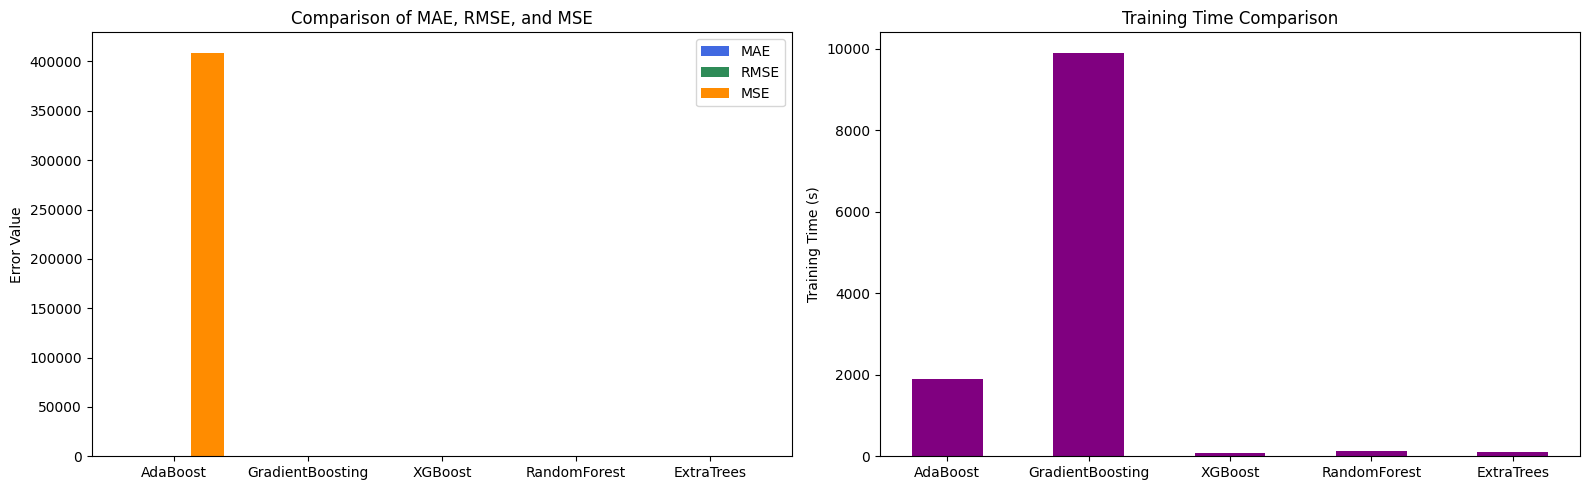

In [17]:
# Values
models = ["AdaBoost", "GradientBoosting", "XGBoost", "RandomForest", "ExtraTrees"]
mae = [549.6232, 4.5461, 4.927, 6.6989, 9.6894]
mse = [409079.5837, 217.232, 229.0913, 266.2612, 419.8398]
rmse = [639.5932, 14.7387, 15.1357, 16.3175, 20.4899]
train_time = [1893.2, 9910.99, 72.09, 117.89, 109.43]

# Visualization
spacing_factor = 1
x = np.arange(len(models)) * spacing_factor
width = 0.25

colors = ["royalblue", "seagreen", "darkorange"]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Metrics
axes[0].bar(x - width, mae, width=width, color=colors[0], label="MAE")
axes[0].bar(x, rmse, width=width, color=colors[1], label="RMSE")
axes[0].bar(x + width, mse, width=width, color=colors[2], label="MSE")

axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel("Error Value")
axes[0].set_title("Comparison of MAE, RMSE, and MSE")
axes[0].legend()

# Training time
axes[1].bar(x, train_time, width=0.5, color="purple")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].set_ylabel("Training Time (s)")
axes[1].set_title("Training Time Comparison")

plt.tight_layout()
plt.show()


### Identified Observations
The Mean Absolute Error (MAE) and the Mean Squared Error (MSE/RMSE) provide insight into the precision of the models.

- Gradient Boosting achieved the best MAE (4.55) and RMSE (14.74), making it the most accurate model for this task.
- XGBoost follows closely with an MAE of 4.93 and RMSE of 15.14, indicating strong predictive performance.
- Random Forest exhibited a slightly higher MAE (6.70) and RMSE (16.32), suggesting it is less precise than the boosting-based models.
- Extra Trees performed worse, with an MAE of 9.69 and RMSE of 20.49, indicating lower predictive accuracy.
- AdaBoost had the poorest performance, with a significantly higher MAE (549.62) and RMSE (639.59), making it unsuitable for this task.

Training Time Analysis
- Gradient Boosting required the longest training time (9910s), which is expected due to its iterative nature.
- XGBoost trained significantly faster (72s) while maintaining strong accuracy, making it a balanced choice.
- Random Forest and Extra Trees required 117s and 109s, respectively, reflecting the computational cost of Bagging techniques.
- AdaBoost had a training time of 1893s but performed poorly, making it an inefficient choice.

General Considerations
- Gradient Boosting is the most effective model in terms of accuracy but comes at a very high computational cost.
- XGBoost offers a strong balance between accuracy and training efficiency, making it a competitive option.
- Random Forest does not provide a substantial advantage over boosting techniques and it is computationally expensive.
- Extra Trees demonstrates the weakest trade-off between accuracy and efficiency.
- AdaBoost is not suitable for this task due to its significantly higher prediction error.

Given these observations, **XGBoost** appears to be the most promising model, offering an optimal balance between predictive accuracy and computational efficiency. However, if computational resources are not a constraint, Gradient Boosting provides the best accuracy.